### 1. Setup and Dependencies

In [1]:
import optuna
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix)
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### 2. MLflow Configuration

In [ ]:
# MLflow Configuration
MLFLOW_TRACKING_URI = "http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/"
EXPERIMENT_NAME = "Final Model LightGBM ADASYN HPT - Exp 6"

# Model Configuration
NGRAM_RANGE = (1, 2)
MAX_FEATURES = 1000
N_TRIALS = 100
RANDOM_STATE = 42

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print("\n--- CONFIGURATION ---")
print(f"Vectorizer: TF-IDF")
print(f"N-gram Range: {NGRAM_RANGE}")
print(f"Max Features: {MAX_FEATURES}")
print(f"Imbalance Method: ADASYN")
print(f"Model: LightGBM")
print(f"HPT Trials: {N_TRIALS}")
print(f"Random State: {RANDOM_STATE}")

2025/11/15 21:47:33 INFO mlflow.tracking.fluent: Experiment with name 'Experiment 8 - Final Model LightGBM ADASYN HPT' does not exist. Creating a new experiment.



--- CONFIGURATION ---
Vectorizer: TF-IDF
N-gram Range: (1, 2)
Max Features: 1000
Imbalance Method: ADASYN
Model: LightGBM
HPT Trials: 100
Random State: 42


### 3. Data Loading 

In [6]:
# Load data
df = pd.read_csv('../data/reddit_preprocessing.csv').dropna(subset=['clean_comment'])

# Remap labels: -1 -> 2, 0 -> 0, 1 -> 1
df['category'] = df['category'].map({-1: 2, 0: 0, 1: 1})
df = df.dropna(subset=['category'])

print(f"Data shape: {df.shape}")
print(f"\nClass distribution:")
print(df['category'].value_counts().sort_index())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_comment'], df['category'], 
    test_size=0.2, random_state=RANDOM_STATE, stratify=df['category']
)

print(f"\nTrain size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

vectorizer = TfidfVectorizer(ngram_range=NGRAM_RANGE, max_features=MAX_FEATURES)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Training features shape: {X_train_vec.shape}")
print(f"Test features shape: {X_test_vec.shape}")


Data shape: (36662, 2)

Class distribution:
category
0    12644
1    15770
2     8248
Name: count, dtype: int64

Train size: 29329
Test size: 7333

FEATURE ENGINEERING
Training features shape: (29329, 1000)
Test features shape: (7333, 1000)


### Imbalance Handling

In [7]:
print(f"Original training class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

sampler = ADASYN(random_state=RANDOM_STATE)
X_train_res, y_train_res = sampler.fit_resample(X_train_vec, y_train)

print(f"\nResampled training class distribution:")
print(pd.Series(y_train_res).value_counts().sort_index())
print(f"Resampled training data shape: {X_train_res.shape}")

Original training class distribution:
category
0    10115
1    12616
2     6598
Name: count, dtype: int64

Resampled training class distribution:
category
0    10989
1    12616
2    12304
Name: count, dtype: int64
Resampled training data shape: (35909, 1000)


### 4. Extensive Hyperparameter Tuning with Optuna

In [8]:
print("\n" + "="*80)
print(f"HYPERPARAMETER TUNING: {N_TRIALS} TRIALS")
print("="*80)

def objective(trial):
    """Optuna objective function for LightGBM hyperparameter tuning."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
    }
    
    model = LGBMClassifier(
        random_state=RANDOM_STATE,
        verbose=-1,
        n_jobs=-1,
        **params
    )
    
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_vec)
    
    # Optimize for weighted F1-score
    return f1_score(y_test, y_pred, average='weighted')

# Run optimization
print(f"Starting optimization at {datetime.now().strftime('%H:%M:%S')}")
print("Optimizing for: Weighted F1-Score")
print("-" * 80)

study = optuna.create_study(direction='maximize', study_name='LightGBM_ADASYN_HPT')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "-" * 80)
print(f"Optimization complete at {datetime.now().strftime('%H:%M:%S')}")
print(f"\nBest weighted F1-score: {study.best_value:.6f}")
print(f"\nBest hyperparameters:")
for param, value in study.best_params.items():
    print(f"  {param}: {value}")

[I 2025-11-15 21:49:31,936] A new study created in memory with name: LightGBM_ADASYN_HPT



HYPERPARAMETER TUNING: 100 TRIALS
Starting optimization at 21:49:31
Optimizing for: Weighted F1-Score
--------------------------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-15 21:49:39,358] Trial 0 finished with value: 0.707517109497646 and parameters: {'n_estimators': 223, 'learning_rate': 0.003747579798311997, 'num_leaves': 26, 'max_depth': 14, 'min_child_samples': 88, 'subsample': 0.5872933383433289, 'colsample_bytree': 0.5180822375648501, 'reg_alpha': 8.81437801864781e-08, 'reg_lambda': 1.1879062793736082, 'min_split_gain': 0.6809223095210348}. Best is trial 0 with value: 0.707517109497646.
[I 2025-11-15 21:49:45,625] Trial 1 finished with value: 0.7850545059763328 and parameters: {'n_estimators': 216, 'learning_rate': 0.18156189614959142, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 24, 'subsample': 0.675414295239749, 'colsample_bytree': 0.7282570793297504, 'reg_alpha': 0.006468958848948261, 'reg_lambda': 4.904751828838895, 'min_split_gain': 0.5060744866970558}. Best is trial 1 with value: 0.7850545059763328.
[I 2025-11-15 21:49:50,108] Trial 2 finished with value: 0.6963262274299935 and parameters: {'n_estimators': 185, 'learnin

### 5. Train Final Model with Best Parameters

In [9]:
print("\n" + "="*80)
print("TRAINING FINAL MODEL")
print("="*80)

best_params = study.best_params

final_model = LGBMClassifier(
    random_state=RANDOM_STATE,
    verbose=-1,
    n_jobs=-1,
    **best_params
)

final_model.fit(X_train_res, y_train_res)
print("Training complete!")



TRAINING FINAL MODEL
Training complete!


### 6. Comprehensive Evaluation

In [10]:
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred = final_model.predict(X_test_vec)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n--- EVALUATION METRICS ---")
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision (macro): {precision_macro:.6f}")
print(f"Precision (weighted): {precision_weighted:.6f}")
print(f"Recall (macro): {recall_macro:.6f}")
print(f"Recall (weighted): {recall_weighted:.6f}")
print(f"F1-Score (macro): {f1_macro:.6f}")
print(f"F1-Score (weighted): {f1_weighted:.6f}")

print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n--- CONFUSION MATRIX ---")
print(cm)

# Cross-Validation
print("\n--- CROSS-VALIDATION ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(final_model, X_train_res, y_train_res, cv=cv, scoring='f1_weighted')
print(f"CV F1-Score (weighted): {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")



MODEL EVALUATION

--- EVALUATION METRICS ---
Accuracy: 0.794627
Precision (macro): 0.784064
Precision (weighted): 0.800629
Recall (macro): 0.777135
Recall (weighted): 0.794627
F1-Score (macro): 0.774233
F1-Score (weighted): 0.791073

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0     0.7571    0.9529    0.8438      2529
           1     0.8806    0.7597    0.8157      3154
           2     0.7145    0.6188    0.6632      1650

    accuracy                         0.7946      7333
   macro avg     0.7841    0.7771    0.7742      7333
weighted avg     0.8006    0.7946    0.7911      7333


--- CONFUSION MATRIX ---
[[2410   41   78]
 [ 428 2396  330]
 [ 345  284 1021]]

--- CROSS-VALIDATION ---
CV F1-Score (weighted): 0.792608 (+/- 0.008930)


### 7. Visualizations


GENERATING VISUALIZATIONS
Visualization saved: exp8_lightgbm_adasyn_evaluation.png


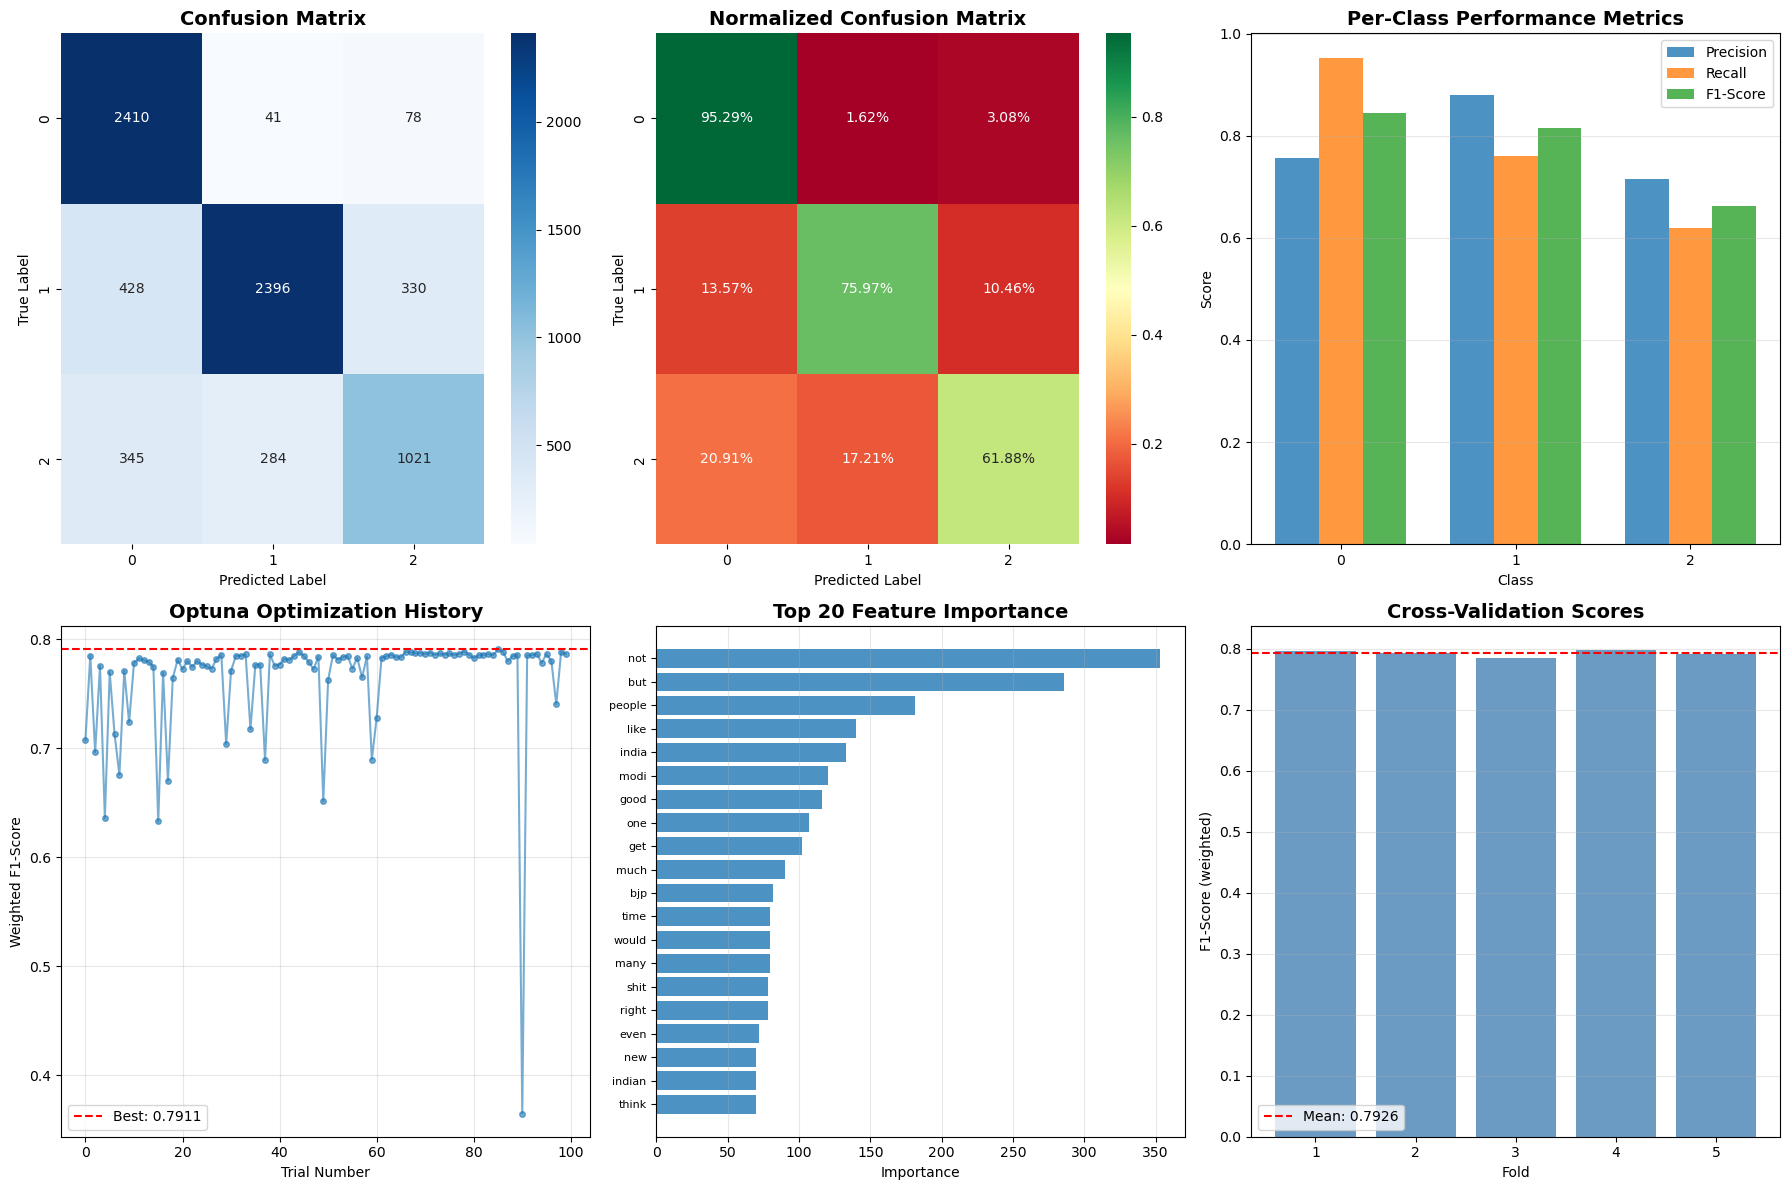

In [11]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Confusion Matrix
ax1 = axes[0, 0]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# 2. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
ax2 = axes[0, 1]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2)
ax2.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

# 3. Per-Class Performance
classes = np.unique(y_test)
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

ax3 = axes[0, 2]
x = np.arange(len(classes))
width = 0.25
ax3.bar(x - width, precision_per_class, width, label='Precision', alpha=0.8)
ax3.bar(x, recall_per_class, width, label='Recall', alpha=0.8)
ax3.bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.8)
ax3.set_xlabel('Class')
ax3.set_ylabel('Score')
ax3.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(classes)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Optuna Optimization History
ax4 = axes[1, 0]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value for t in study.trials]
ax4.plot(trial_numbers, trial_values, 'o-', alpha=0.6, markersize=4)
ax4.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best: {study.best_value:.4f}')
ax4.set_xlabel('Trial Number')
ax4.set_ylabel('Weighted F1-Score')
ax4.set_title('Optuna Optimization History', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Feature Importance (Top 20)
ax5 = axes[1, 1]
feature_importance = final_model.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_indices = np.argsort(feature_importance)[-20:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

ax5.barh(range(len(top_features)), top_importance, alpha=0.8)
ax5.set_yticks(range(len(top_features)))
ax5.set_yticklabels(top_features, fontsize=8)
ax5.set_xlabel('Importance')
ax5.set_title('Top 20 Feature Importance', fontsize=14, fontweight='bold')
ax5.grid(axis='x', alpha=0.3)

# 6. Cross-Validation Scores
ax6 = axes[1, 2]
ax6.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.8, color='steelblue')
ax6.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
ax6.set_xlabel('Fold')
ax6.set_ylabel('F1-Score (weighted)')
ax6.set_title('Cross-Validation Scores', fontsize=14, fontweight='bold')
ax6.set_xticks(range(1, len(cv_scores) + 1))
ax6.legend()
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plot_filename = 'exp8_lightgbm_adasyn_evaluation.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"Visualization saved: {plot_filename}")
plt.show()


### 8. Log to MLflow

In [12]:
print("\n" + "="*80)
print("LOGGING TO MLFLOW")
print("="*80)

with mlflow.start_run() as run:
    # Set tags
    mlflow.set_tag("mlflow.runName", "LightGBM_ADASYN_Final_Model_HPT")
    mlflow.set_tag("experiment_type", "final_model_selection")
    mlflow.set_tag("model_type", "LightGBM")
    
    # Log preprocessing parameters
    mlflow.log_param("vectorizer_type", "TF-IDF")
    mlflow.log_param("ngram_range", str(NGRAM_RANGE))
    mlflow.log_param("max_features", MAX_FEATURES)
    mlflow.log_param("imbalance_method", "ADASYN")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("random_state", RANDOM_STATE)
    
    # Log best hyperparameters
    for param, value in best_params.items():
        mlflow.log_param(param, value)
    
    # Log overall metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_macro", precision_macro)
    mlflow.log_metric("precision_weighted", precision_weighted)
    mlflow.log_metric("recall_macro", recall_macro)
    mlflow.log_metric("recall_weighted", recall_weighted)
    mlflow.log_metric("f1_macro", f1_macro)
    mlflow.log_metric("f1_weighted", f1_weighted)
    mlflow.log_metric("cv_f1_mean", cv_scores.mean())
    mlflow.log_metric("cv_f1_std", cv_scores.std())
    
    # Log per-class metrics
    for idx, class_label in enumerate(classes):
        mlflow.log_metric(f"{class_label}_precision", precision_per_class[idx])
        mlflow.log_metric(f"{class_label}_recall", recall_per_class[idx])
        mlflow.log_metric(f"{class_label}_f1-score", f1_per_class[idx])
    
    # Log model
    mlflow.sklearn.log_model(final_model, "final_lightgbm_model")
    
    # Log artifacts
    mlflow.log_artifact(plot_filename)
    
    print("Successfully logged to MLflow!")
    print(f"Run ID: {run.info.run_id}")


LOGGING TO MLFLOW


2025/11/15 22:02:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 22:03:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Successfully logged to MLflow!
Run ID: 4640eed4523d47f99ca1e38ee5d52970
🏃 View run LightGBM_ADASYN_Final_Model_HPT at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/19/runs/4640eed4523d47f99ca1e38ee5d52970
🧪 View experiment at: http://ec2-54-211-18-166.compute-1.amazonaws.com:5000/#/experiments/19


### 9. Save Final Model

In [13]:
print("\n" + "="*80)
print("SAVING MODEL AND PARAMETERS")
print("="*80)

# Save model
model_filename = f'final_lightgbm_adasyn_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved as: {model_filename}")

# Save vectorizer
vectorizer_filename = f'tfidf_vectorizer_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pkl'
joblib.dump(vectorizer, vectorizer_filename)
print(f"Vectorizer saved as: {vectorizer_filename}")

# Save parameters and results
params_filename = f'exp8_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'
with open(params_filename, 'w') as f:
    f.write("EXPERIMENT 8: FINAL MODEL SUMMARY\n")
    f.write("="*80 + "\n\n")
    
    f.write("MODEL CONFIGURATION\n")
    f.write("-"*80 + "\n")
    f.write(f"Algorithm: LightGBM\n")
    f.write(f"Imbalance Method: ADASYN\n")
    f.write(f"Vectorizer: TF-IDF\n")
    f.write(f"N-gram Range: {NGRAM_RANGE}\n")
    f.write(f"Max Features: {MAX_FEATURES}\n")
    f.write(f"HPT Trials: {N_TRIALS}\n")
    f.write(f"Random State: {RANDOM_STATE}\n\n")
    
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-"*80 + "\n")
    for param, value in best_params.items():
        f.write(f"{param}: {value}\n")
    f.write("\n")
    
    f.write("EVALUATION METRICS\n")
    f.write("-"*80 + "\n")
    f.write(f"Accuracy: {accuracy:.6f}\n")
    f.write(f"Weighted F1-Score: {f1_weighted:.6f}\n")
    f.write(f"Weighted Precision: {precision_weighted:.6f}\n")
    f.write(f"Weighted Recall: {recall_weighted:.6f}\n")
    f.write(f"Macro F1-Score: {f1_macro:.6f}\n")
    f.write(f"CV F1-Score: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})\n")
    f.write("\n")
    
    f.write("PER-CLASS METRICS\n")
    f.write("-"*80 + "\n")
    class_names = ['Positive (0)', 'Neutral (1)', 'Negative (2)']
    for idx, (class_label, class_name) in enumerate(zip(classes, class_names)):
        f.write(f"\nClass {class_label} - {class_name}:\n")
        f.write(f"  Precision: {precision_per_class[idx]:.6f}\n")
        f.write(f"  Recall: {recall_per_class[idx]:.6f}\n")
        f.write(f"  F1-Score: {f1_per_class[idx]:.6f}\n")
    
    f.write("\n")
    f.write("CONFUSION MATRIX\n")
    f.write("-"*80 + "\n")
    f.write(str(cm))
    f.write("\n")

print(f"Results saved as: {params_filename}")


SAVING MODEL AND PARAMETERS
Model saved as: final_lightgbm_adasyn_model_20251115_220346.pkl
Vectorizer saved as: tfidf_vectorizer_20251115_220347.pkl
Results saved as: exp8_results_20251115_220347.txt


### 10. Summary

In [14]:
print("\n" + "="*80)
print("EXPERIMENT 8 SUMMARY")
print("="*80)
print(f"Completion Time: {datetime.now()}")

print(f"\n📊 CONFIGURATION:")
print(f"  • Vectorizer: TF-IDF (Bigrams 1-2, max_features={MAX_FEATURES})")
print(f"  • Imbalance Handling: ADASYN")
print(f"  • Model: LightGBM")
print(f"  • HPT Trials: {N_TRIALS}")

print(f"\n🎯 BEST HYPERPARAMETERS:")
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  • {param}: {value:.6f}")
    else:
        print(f"  • {param}: {value}")

print(f"\n📈 PERFORMANCE METRICS:")
print(f"  • Test Accuracy: {accuracy:.6f} ({accuracy*100:.2f}%)")
print(f"  • Weighted F1-Score: {f1_weighted:.6f}")
print(f"  • Weighted Precision: {precision_weighted:.6f}")
print(f"  • Weighted Recall: {recall_weighted:.6f}")
print(f"  • CV F1-Score: {cv_scores.mean():.6f} (+/- {cv_scores.std() * 2:.6f})")

print(f"\n🎯 PER-CLASS F1-SCORES:")
class_names = ['Positive', 'Neutral', 'Negative (Minority)']
for idx, class_name in enumerate(class_names):
    print(f"  • {class_name}: {f1_per_class[idx]:.6f}")

print(f"\n💾 SAVED FILES:")
print(f"  • Model: {model_filename}")
print(f"  • Vectorizer: {vectorizer_filename}")
print(f"  • Results: {params_filename}")
print(f"  • Visualization: {plot_filename}")

print("\n" + "="*80)
print("✅ EXPERIMENT COMPLETE!")
print("="*80)
print("\n🚀 This model is ready for deployment!")
print("   Use the saved model and vectorizer for predictions on new data.")


EXPERIMENT 8 SUMMARY
Completion Time: 2025-11-15 22:03:58.955365

📊 CONFIGURATION:
  • Vectorizer: TF-IDF (Bigrams 1-2, max_features=1000)
  • Imbalance Handling: ADASYN
  • Model: LightGBM
  • HPT Trials: 100

🎯 BEST HYPERPARAMETERS:
  • n_estimators: 282
  • learning_rate: 0.189180
  • num_leaves: 23
  • max_depth: 5
  • min_child_samples: 5
  • subsample: 0.773541
  • colsample_bytree: 0.669102
  • reg_alpha: 0.000000
  • reg_lambda: 0.000050
  • min_split_gain: 0.159807

📈 PERFORMANCE METRICS:
  • Test Accuracy: 0.794627 (79.46%)
  • Weighted F1-Score: 0.791073
  • Weighted Precision: 0.800629
  • Weighted Recall: 0.794627
  • CV F1-Score: 0.792608 (+/- 0.008930)

🎯 PER-CLASS F1-SCORES:
  • Positive: 0.843838
  • Neutral: 0.815660
  • Negative (Minority): 0.663202

💾 SAVED FILES:
  • Model: final_lightgbm_adasyn_model_20251115_220346.pkl
  • Vectorizer: tfidf_vectorizer_20251115_220347.pkl
  • Results: exp8_results_20251115_220347.txt
  • Visualization: exp8_lightgbm_adasyn_evalua